In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs import text
from postprocessing import similarity
from postprocessing import bias

# Setup

In [3]:
FACTUALITY_PATH = '../results/factuality'
APS_OA_DATA_TAR_GZ = '../../APS/data/final_dataset.tar.gz'
NOBEL_FN = '../data/organised_data/nobel_prize_with_openalex.json'
PLOTS_PATH = '../results/plots'
LATEX_PATH = '../results/latex'

io.validate_path(LATEX_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_aps_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHOR_STATS_FN)
df_aps_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_aps_stats.shape

(481012, 9)

In [6]:
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_all_authors_stats = df_all_authors_stats.merge(df_aps_stats, on='id_author_oa', how='left')
df_all_authors_stats.shape

(481012, 38)

In [7]:
df_llm_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_llm_real_authors = df_llm_authors.copy()
df_llm_real_authors = df_llm_real_authors[['id_author_oa','clean_name','model','task_name','task_param','date','time']].merge(df_all_authors_stats, on='id_author_oa', how='left')
df_llm_real_authors.dropna(subset=['id_author_oa'], inplace=True)
df_llm_real_authors['task_name'] = io.pd.Categorical(df_llm_real_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_llm_real_authors.shape

(108028, 44)

In [8]:
df_nobel_prize_winners = io.pd.DataFrame(io.read_json_file(NOBEL_FN))
df_nobel_prize_winners['decade'] = (df_nobel_prize_winners['year'] // 10) * 10
df_nobel_prize_winners['decade'] = df_nobel_prize_winners['decade'].apply(lambda x: str(int(x)))
df_nobel_prize_winners.shape

(1000, 9)

#  All responses

In [9]:
df_llm_real_authors.groupby('model').id_author_oa.nunique(), df_all_authors_stats.id_author_oa.nunique()

(model
 gemma2-9b          14
 llama-3.1-70b    1047
 llama-3.1-8b      150
 llama3-70b        550
 llama3-8b         288
 mixtral-8x7b      218
 Name: id_author_oa, dtype: int64,
 481012)

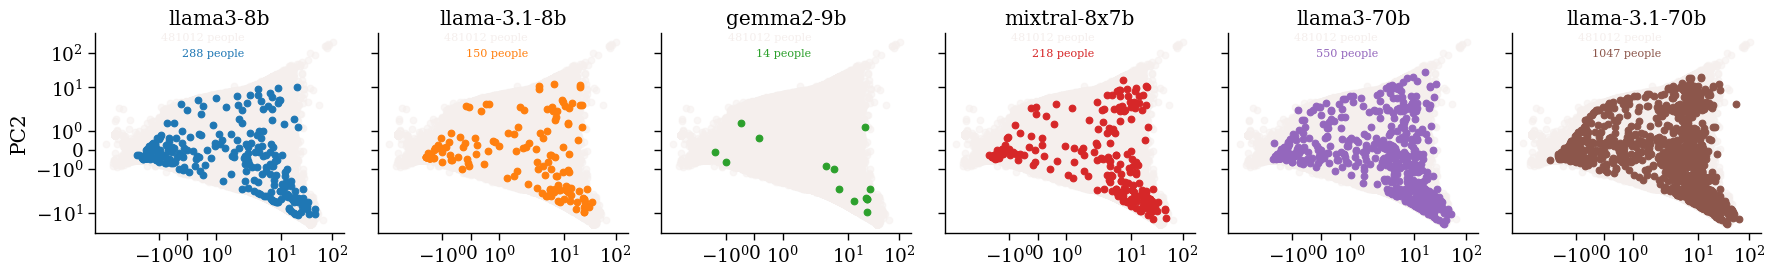

In [10]:
fn = io.path_join(PLOTS_PATH, 'components_by_model_all.pdf')
results,loadings = similarity.get_components_by_model(df_llm_real_authors, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL)

vis.plot_components_by_model_including_population(results, colors=constants.LLMS_COLORS,
                                                  col_order = constants.LLMS,
                                                  xlabel=None,
                                                #   xticks=None,
                                                  width=3, height=3,
                                                  fn=fn,
                                                  xscale='symlog',
                                                  yscale='symlog',
                                                  legend=False)

# Top-K

In [11]:
task_name = 'top_k'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      top_5           3
llama-3.1-70b  top_100       520
               top_5          16
llama-3.1-8b   top_100        52
               top_5           4
llama3-70b     top_100       356
               top_5           5
llama3-8b      top_5           5
mixtral-8x7b   top_100        37
               top_5           4
Name: id_author_oa, dtype: int64

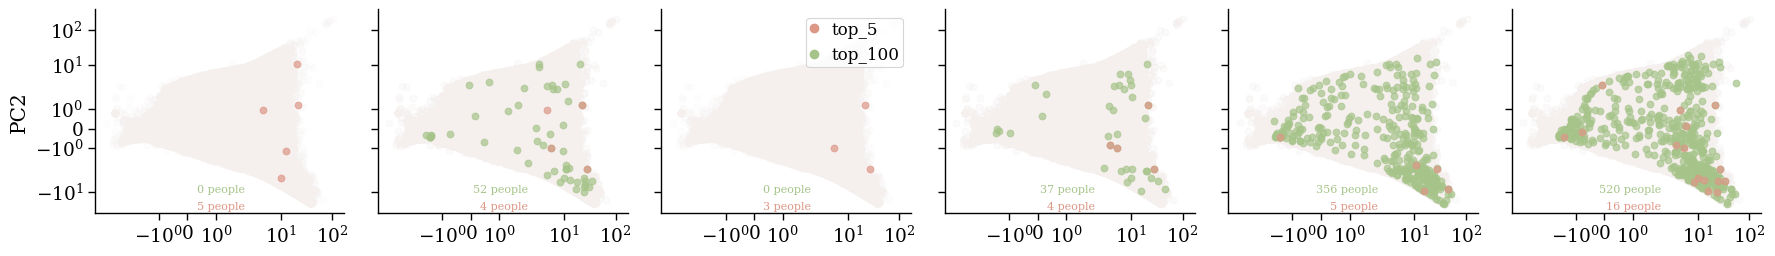

In [12]:
task_name = 'top_k'
categories = constants.TASK_TOPK_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results,loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  # xticks=None,
                                                                #   ylabel=None,
                                                                #   yticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

In [13]:
for group, _tmp in subset.query("task_param=='top_5'").groupby('model'):
    
    print(group)
    print(_tmp.name.unique())
    print()


group_counts = subset.query("task_param=='top_5' and model=='llama-3.1-70b'")['name'].value_counts()
group_counts.head(5)


gemma2-9b
['Albert Einstein' 'Richard P. Feynman' 'S. W. Hawking']

llama-3.1-70b
['Albert Einstein' 'Richard P. Feynman' 'S. W. Hawking'
 'Murray Gell- Mann' 'Frank Wilczek' 'D. J. Wineland' 'Andrew Strominger'
 'Lisa Randall' 'Niels Bohr' 'Brian Greene' 'A. B. McDonald'
 'Erwin Schrödinger' 'John Bardeen' 'Phillip A. Anderson' 'D. C. Tsui'
 'Sheldon L. Glashow']

llama-3.1-8b
['S. W. Hawking' 'Richard P. Feynman' 'Albert Einstein' 'Brian Greene']

llama3-70b
['Richard P. Feynman' 'Murray Gell- Mann' 'Leon M. Lederman'
 'Sheldon L. Glashow' 'Steven Weinberg']

llama3-8b
['S. W. Hawking' 'Edward Witten' 'Lisa Randall' 'Sean M. Carroll'
 'Brian Greene']

mixtral-8x7b
['Albert Einstein' 'S. W. Hawking' 'Richard P. Feynman' 'Niels Bohr']



name
Richard P. Feynman    91
S. W. Hawking         90
Murray Gell- Mann     65
Frank Wilczek         62
Albert Einstein       56
Name: count, dtype: int64

In [14]:
key = ('llama3-8b','top_k','top_5')
print(results[key])
print()
print(loadings[key])

{'reduction':         aps_works_count  aps_cited_by_count  aps_h_index  aps_i10_index  \
0                   1.0                 0.0          0.0            0.0   
1                  30.0               485.0         14.0           18.0   
2                   0.0                 0.0          0.0            0.0   
3                   0.0                 0.0          0.0            0.0   
4                 126.0              1967.0         15.0           63.0   
...                 ...                 ...          ...            ...   
481012             56.0              4579.0         35.0           45.0   
481013             27.0              2437.0         24.0           24.0   
481014             24.0              4222.0         15.0           16.0   
481015             57.0              2704.0         22.0           37.0   
481016             12.0               386.0          9.0            8.0   

        aps_e_index  aps_citations_per_paper_age  aps_career_age  works_count  \
0   

# Field

In [15]:
task_name = 'field'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      PER             3
llama-3.1-70b  CM&MP         223
               PER            28
llama-3.1-8b   PER            17
llama3-70b     CM&MP          38
               PER            27
llama3-8b      CM&MP          37
               PER            12
mixtral-8x7b   CM&MP          20
               PER            22
Name: id_author_oa, dtype: int64

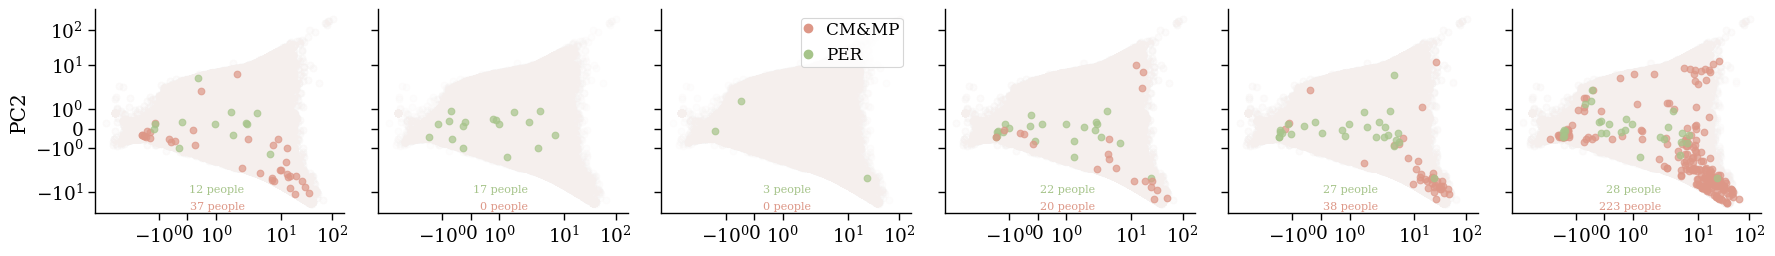

In [16]:
task_name = 'field'
categories = constants.TASK_FIELD_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  # xticks=None,
                                                                #   ylabel=None,
                                                                #   yticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

In [17]:
key = ('llama3-8b','field','CM&MP')
print(results[key])
print()
print(loadings[key])

{'reduction':         aps_works_count  aps_cited_by_count  aps_h_index  aps_i10_index  \
0                   1.0                 0.0          0.0            0.0   
1                  30.0               485.0         14.0           18.0   
2                   0.0                 0.0          0.0            0.0   
3                   0.0                 0.0          0.0            0.0   
4                 126.0              1967.0         15.0           63.0   
...                 ...                 ...          ...            ...   
481044             59.0              3103.0         15.0           34.0   
481045             31.0               272.0          8.0            9.0   
481046              0.0                 0.0          0.0            0.0   
481047             81.0             10878.0         39.0           56.0   
481048              1.0                 0.0          0.0            0.0   

        aps_e_index  aps_citations_per_paper_age  aps_career_age  works_count  \
0   

# Epoch

In [18]:
task_name = 'epoch'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      1950s           9
llama-3.1-70b  1950s          56
               2000s         168
llama-3.1-8b   1950s          36
llama3-70b     1950s          17
               2000s          54
llama3-8b      1950s          11
mixtral-8x7b   1950s          18
               2000s           7
Name: id_author_oa, dtype: int64

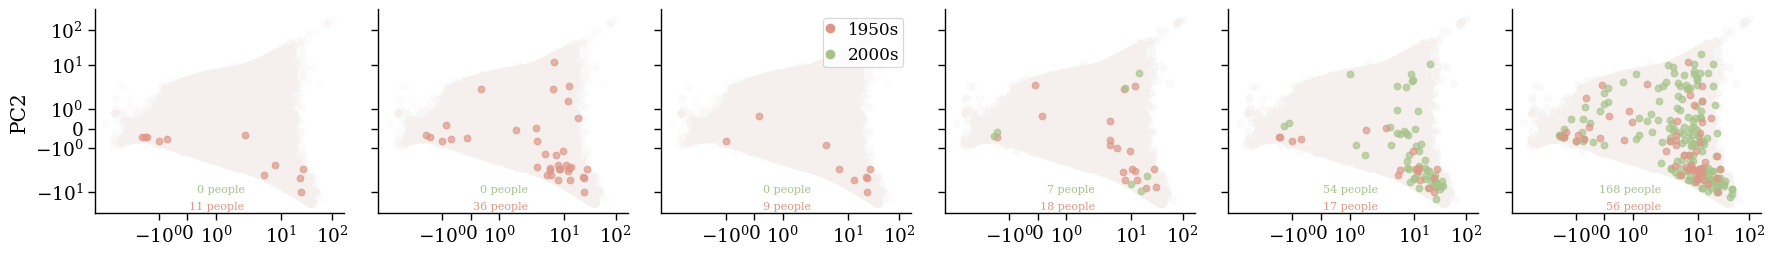

In [19]:
task_name = 'epoch'
categories = constants.TASK_EPOCH_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                #   xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

# Seniority

In [20]:
task_name = 'seniority'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param  
llama-3.1-70b  early_career    104
               senior           58
llama-3.1-8b   early_career      6
llama3-70b     early_career      1
               senior          121
llama3-8b      early_career     47
               senior           41
mixtral-8x7b   early_career      2
               senior           10
Name: id_author_oa, dtype: int64

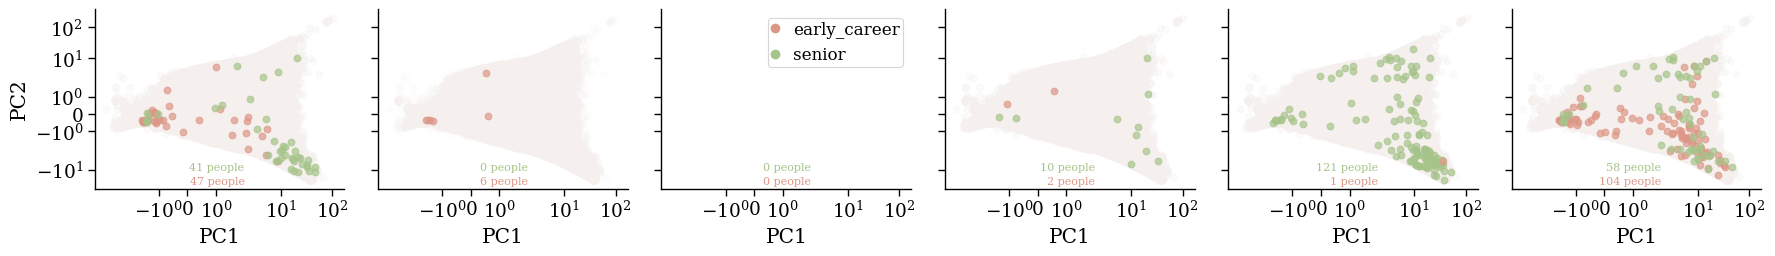

In [21]:
task_name = 'seniority'
categories = constants.TASK_SENIORITY_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                #   xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

# Twins

## Famous

In [22]:
task_name = 'twins'
task_param = 'famous'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param   
llama-3.1-70b  famous_female    27
               famous_male      80
llama-3.1-8b   famous_female     5
               famous_male       7
llama3-70b     famous_female    20
               famous_male      24
llama3-8b      famous_female     3
               famous_male       5
mixtral-8x7b   famous_female     8
Name: id_author_oa, dtype: int64

In [23]:
df_all_authors_stats.query("name.str.contains('Barabási') or name.str.contains('Réka')")
# APS ids
# Réka Albert: 43067
# Albert‐László Barabási: 44475

,id_author_oa,created_date,updated_date,name,orcid,two_year_mean_citedness,h_index,i10_index,works_count,cited_by_count,...,rr7_rank_mean_citedness_2yr,rr7_rank_mean_citedness_2yr_percentile,aps_works_count,aps_cited_by_count,aps_h_index,aps_i10_index,aps_e_index,aps_years_of_activity,aps_career_age,aps_citations_per_paper_age
43067,5012905268,2023-07-21,2024-11-06T05:27:03.143341,Réka Albert,0000-0002-9485-0828,5.277778,61,138,286,88555,...,43067.0,91.046793,19.0,1928.0,11.0,11.0,113.734695,"[1997.0, 2018.0]",22.0,4.612440
44475,5038976962,2023-07-21,2024-11-03T04:26:45.865730,Albert‐László Barabási,0000-0002-4028-3522,5.144928,152,343,663,208295,...,44476.0,90.753869,60.0,3509.0,30.0,44.0,168.482461,"[1990.0, 2016.0]",27.0,2.166049
89737,5026921040,2023-07-21,2024-11-05T09:12:34.567126,Réka Á. Vig,0000-0002-7854-3297,3.000000,4,3,18,72,...,86713.0,81.973007,2.0,4.0,1.0,0.0,-0.000000,"[2018.0, 2020.0]",3.0,0.666667
222077,5009953550,2023-07-21,2024-10-09T10:13:16.208511,Réka Trencsényi,NaN,0.000000,5,1,16,49,...,215401.0,55.219412,1.0,2.0,1.0,0.0,-0.000000,"[2016.0, 2016.0]",1.0,2.000000
245710,5014239544,2023-07-21,2024-10-13T10:30:32.468186,Réka Körei,NaN,0.000000,1,0,2,1,...,215401.0,55.219412,1.0,0.0,0.0,0.0,0.000000,"[2018.0, 2018.0]",1.0,0.000000


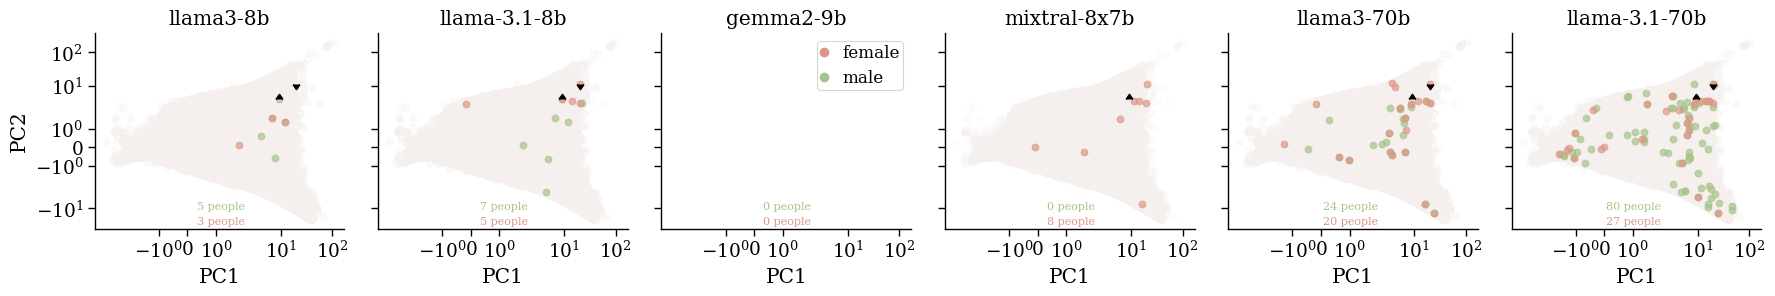

In [24]:
task_name = 'twins'
task_param = 'famous'
categories = constants.TASK_TWINS_FAMOUS_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings  = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  title=True,
                                                                  #xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=3.2,
                                                                  )

In [25]:
tp = "famous_male"
for group, _tmp in subset.query("task_param==@tp").groupby('model'):
    
    print(group)
    print(_tmp.name.unique())
    print()

# group_counts = subset.query("task_param==@tp and model=='llama-3.1-70b'")['name'].value_counts()
# group_counts.head(5)

llama-3.1-70b
['А. А. Абрикосов' 'Per Bak' 'E. Segré' 'Leo P. Kadanoff'
 'Benoît B. Mandelbrot' 'Philip W. Anderson' 'W. Kohn' 'Stuart A. Rice'
 'H. Haken' 'S P Novikov' 'Ya. G. Sinai' 'Grigori Volovik'
 'Vladimir A. Zakharov' 'Alexey O. Polyakov' 'Mikhail Shifman'
 'Michael Atiyah' 'David Deutsch' 'Freeman J. Dyson' 'Murray Gell- Mann'
 'S. W. Hawking' 'W. Heisenberg' 'L.D. LANDAU' 'Edward Witten'
 'Ilya Prigogine' 'Mitchell J. Feigenbaum' 'Robert M. May'
 'Kenneth G. Wilson' 'Stuart Kauffman' 'Stephen Wolfram' 'Yakir Aharonov'
 'David Ruelle' 'Joseph Ford' 'Edward Ott' 'Celso Grebogi'
 'James A. Yorke' 'Predrag Cvitanović' 'Itamar Procaccia'
 'H. Eugene Stanley' 'Liron Levin' 'M. Berry' 'John Cardy'
 'Giorgio Parisi' 'Marc Mézard' 'A. Cavalleri' 'Anton Zilman'
 'Sidney Redner' 'Hernán A. Makse' 'Sergei Maslov' 'Kim Sneppen'
 'Reuven Cohen' 'Shlomo Havlin' 'Duncan J. Watts' 'Albert‐László Barabási'
 'R. B. Laughlin' 'M. W. Newman' 'Steven H. Strogatz'
 'Alessandro Vespignani' 'Vito La

In [26]:
results[('llama3-8b','twins','famous_female')]

{'reduction':         aps_works_count  aps_cited_by_count  aps_h_index  aps_i10_index  \
 0                   1.0                 0.0          0.0            0.0   
 1                  30.0               485.0         14.0           18.0   
 2                   0.0                 0.0          0.0            0.0   
 3                   0.0                 0.0          0.0            0.0   
 4                 126.0              1967.0         15.0           63.0   
 ...                 ...                 ...          ...            ...   
 481010              1.0                 1.0          1.0            0.0   
 481011              1.0                 0.0          0.0            0.0   
 481012             52.0              1902.0         24.0           38.0   
 481013             25.0               142.0          4.0            3.0   
 481014             62.0               677.0         10.0           23.0   
 
         aps_e_index  aps_citations_per_paper_age  aps_career_age  works_

## Random

In [27]:
task_name = 'twins'
task_param = 'random'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param   
llama-3.1-70b  random_female    75
               random_male      57
llama-3.1-8b   random_male      17
llama3-70b     random_female    14
               random_male      19
llama3-8b      random_female     2
               random_male       9
mixtral-8x7b   random_female     2
               random_male      15
Name: id_author_oa, dtype: int64

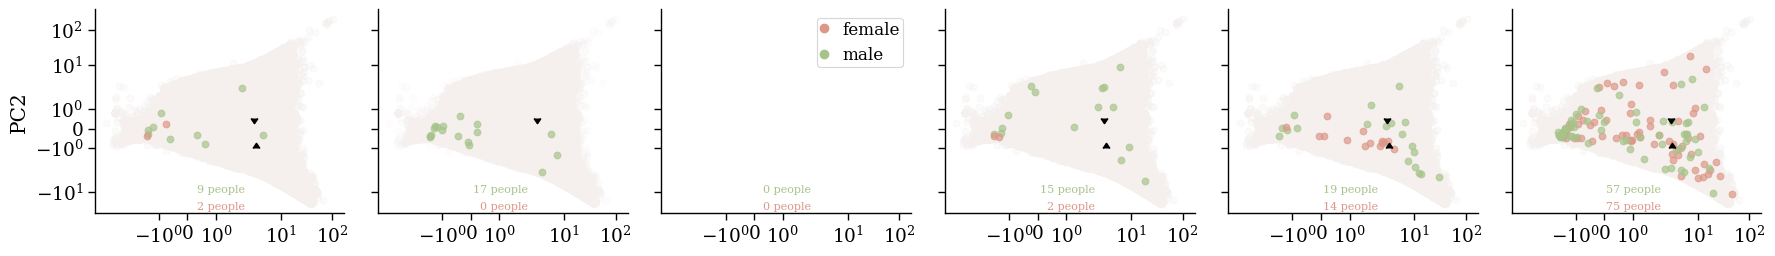

In [28]:
task_name = 'twins'
task_param = 'random'
categories = constants.TASK_TWINS_RANDOM_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

## Politician

In [29]:
task_name = 'twins'
task_param = 'politic'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param    
llama-3.1-70b  politic_female    15
               politic_male      35
llama-3.1-8b   politic_female     2
               politic_male       9
llama3-70b     politic_female    11
               politic_male       4
llama3-8b      politic_female    16
mixtral-8x7b   politic_female    16
               politic_male      17
Name: id_author_oa, dtype: int64

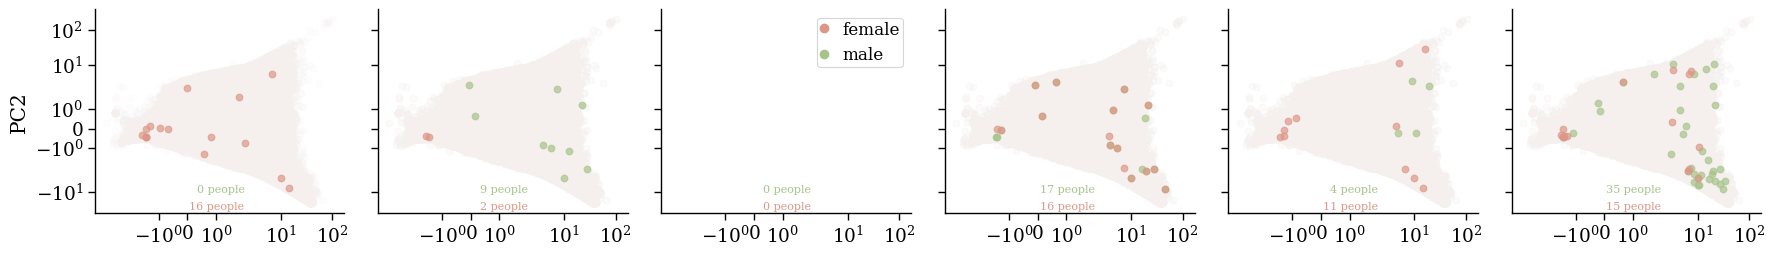

In [30]:
task_name = 'twins'
task_param = 'politic'
categories = constants.TASK_TWINS_POLITIC_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

## TV show

In [31]:
task_name = 'twins'
task_param = 'movie'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param  
llama-3.1-70b  movie_female    29
               movie_male      27
llama-3.1-8b   movie_male       9
llama3-70b     movie_female    16
               movie_male      12
llama3-8b      movie_male       9
mixtral-8x7b   movie_female    75
               movie_male      19
Name: id_author_oa, dtype: int64

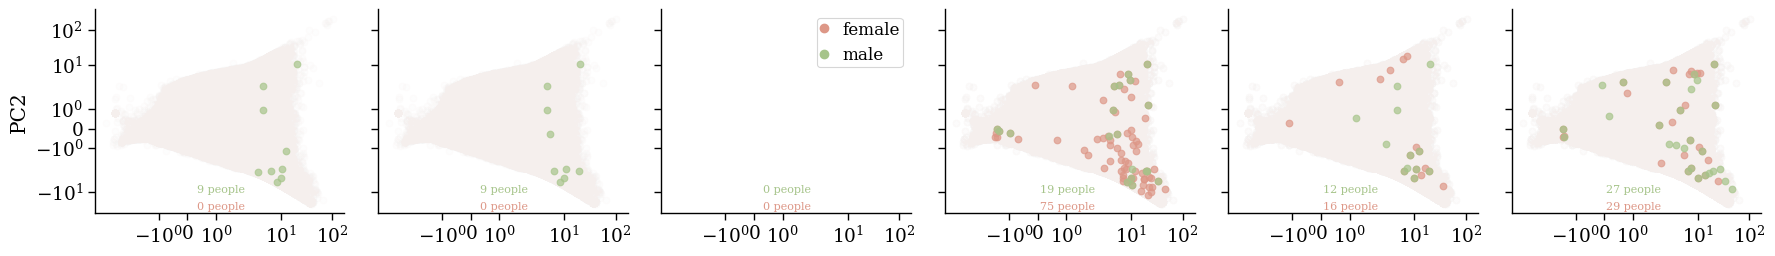

In [32]:
task_name = 'twins'
task_param = 'movie'
categories = constants.TASK_TWINS_MOVIE_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

## Ficticious

In [33]:
task_name = 'twins'
task_param = 'fictitious'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param       
llama-3.1-70b  fictitious_female    64
               fictitious_male      62
llama-3.1-8b   fictitious_female    11
               fictitious_male      26
llama3-70b     fictitious_female    26
               fictitious_male       8
llama3-8b      fictitious_female    46
               fictitious_male      63
mixtral-8x7b   fictitious_female    75
               fictitious_male       1
Name: id_author_oa, dtype: int64

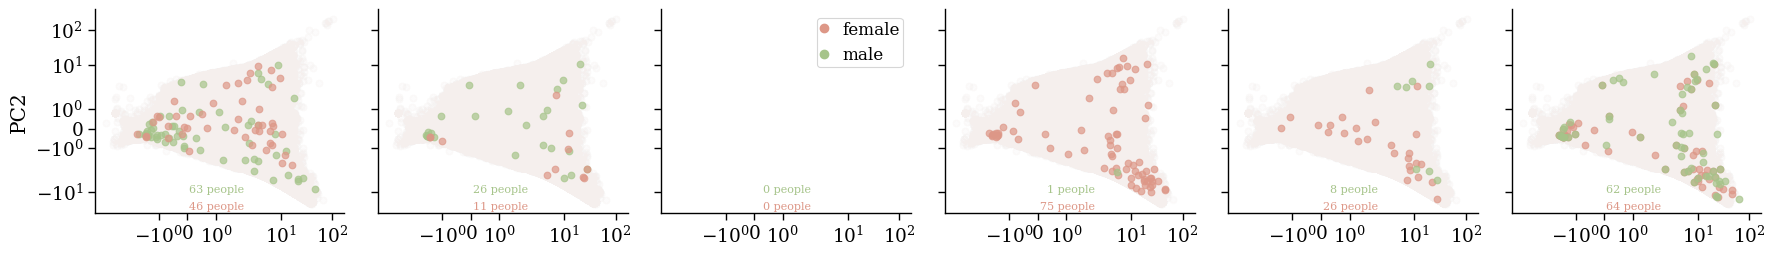

In [34]:
task_name = 'twins'
task_param = 'fictitious'
categories = constants.TASK_TWINS_FICTICIOUS_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results, loadings = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog',
                                                                  width=3, height=2.8,
                                                                  )

___

# Nobel Prize winners

In [35]:
df_authors_nobel = bias.get_nobel_prize_stats(df_llm_real_authors, df_nobel_prize_winners)
df_authors_nobel.head(2)

,model,task_name,task_param,date,time,id_author_oa,clean_name,nobel_category,nobel_year,name,is_nobel,nobel_decade
0,llama3-8b,epoch,1950s,2024-12-09,00:00,5037710835.0,richard feynman,Physics,1965.0,Richard P. Feynman,True,1960
1,llama3-8b,epoch,1950s,2024-12-09,00:00,5088438810.0,julian schwinger,Physics,1965.0,Julian Schwinger,True,1960


In [36]:
# All APS nobel prize winners
df_authors_aps_nobel = bias.get_nobel_prize_stats(df_all_authors_stats, df_nobel_prize_winners)
df_authors_aps_nobel = df_authors_aps_nobel.query("is_nobel==True")
df_authors_aps_nobel.head(2)

,id_author_oa,nobel_category,nobel_year,name,is_nobel,nobel_decade
141,5012651049,Chemistry,2023.0,Louis E. Brus,True,2020
468,5106522067,Physics,2006.0,George F. Smoot,True,2000


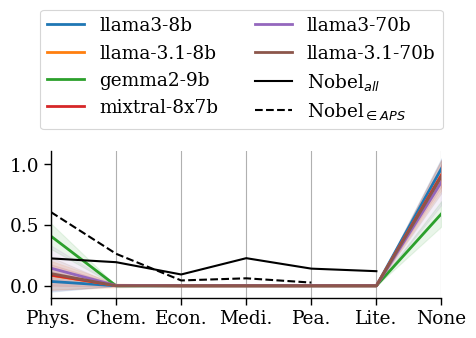

In [37]:
fname = 'nobel_laureates_by_category.pdf'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
x_col = 'nobel_category'
x_order = constants.NOBEL_CATEGORIES
mean_col = 'mean'
std_col = 'std'

df_authors_nobel_stats, _ = bias.get_mean_percentages(df_authors_nobel, x_col, {x_col:x_order})
baselines, _ = bias.get_baselined_from_gt(df_nobel_prize_winners, 'category', x_order[:-1])
baseline_aps, _ = bias.get_baselined_from_gt(df_authors_aps_nobel, 'nobel_category', x_order[:-1])

df_authors_nobel_stats_mean_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_authors_nobel_stats_std_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_authors_nobel_stats_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_authors_nobel_stats_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         baselines={'Nobel$_{all}$':{'values':baselines.drop(columns=['counts']).percentage},
                                    'Nobel$_{\in APS}$':{'values':baseline_aps.drop(columns=['counts']).percentage, 'ls':'--'}},
                         xticklabels_rename = constants.NOBEL_CATEGORIES_RENAME,
                         fn=fn
                         )

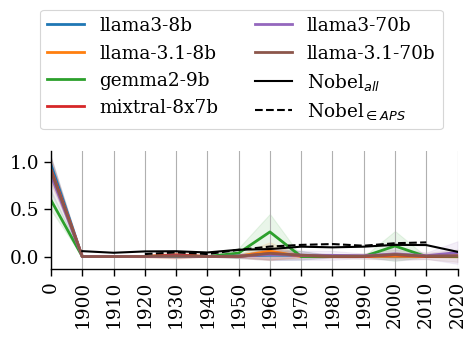

In [38]:
fname = 'nobel_laureates_by_year.pdf'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
x_col = 'nobel_decade'
x_order = constants.NOBEL_DECADES
mean_col = 'mean'
std_col = 'std'

df_authors_nobel_stats, _ = bias.get_mean_percentages(df_authors_nobel, x_col, {x_col:x_order})
baselines, _ = bias.get_baselined_from_gt(df_nobel_prize_winners, 'decade', x_order)
baseline_aps, _ = bias.get_baselined_from_gt(df_authors_aps_nobel, 'nobel_decade', x_order[:-1])

df_authors_nobel_stats_mean_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_authors_nobel_stats_std_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_authors_nobel_stats_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_authors_nobel_stats_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         xlabel_rotation=90,
                         baselines={'Nobel$_{all}$':{'values':baselines.drop(columns=['counts']).percentage},
                                    'Nobel$_{\in APS}$':{'values':baseline_aps.drop(columns=['counts']).percentage, 'ls':'--'}},
                         fn=fn
                         )

___

# Rankings

In [39]:
df_ranking_rec_stats = df_llm_real_authors.copy() 
df_ranking_rec_stats.drop_duplicates(subset=['model','id_author_oa'], inplace=True)
df_ranking_rec_stats.shape

(2267, 44)

In [40]:
df_ranking_rec_stats.loc[:,'aps_citations_per_paper_age'] = df_ranking_rec_stats.loc[:,'aps_cited_by_count'] / df_ranking_rec_stats.loc[:,'aps_works_count'] / df_ranking_rec_stats.loc[:,'aps_career_age']  
df_all_authors_stats.loc[:,'aps_citations_per_paper_age'] = df_all_authors_stats.loc[:,'aps_cited_by_count'] / df_all_authors_stats.loc[:,'aps_works_count'] / df_all_authors_stats.loc[:,'aps_career_age']  

## Works count (number of publications)

aps_works_count


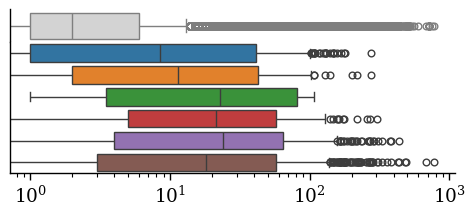

In [41]:
metric = 'aps_works_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                   )

works_count


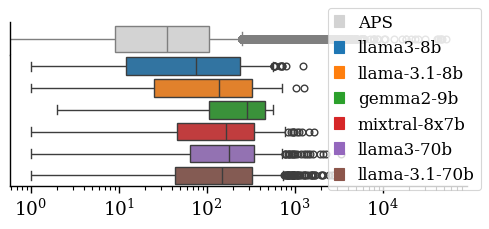

In [42]:
metric = 'works_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=True, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn,
                                )

## Citations

aps_cited_by_count


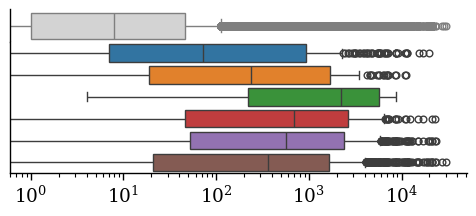

In [43]:
metric = 'aps_cited_by_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

cited_by_count


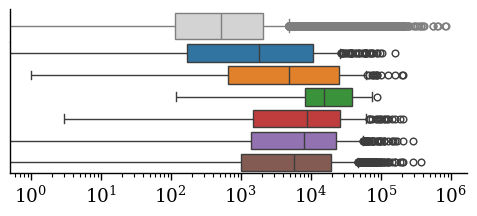

In [44]:
metric = 'cited_by_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## h-index

aps_h_index


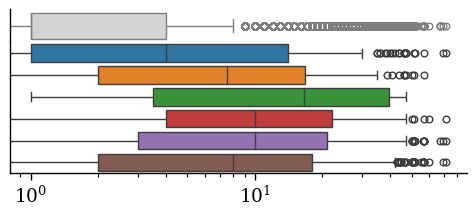

In [45]:
metric = 'aps_h_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

h_index


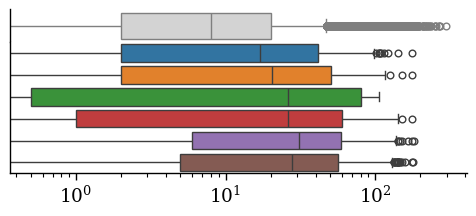

In [46]:
metric = 'h_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## i10-index

aps_i10_index


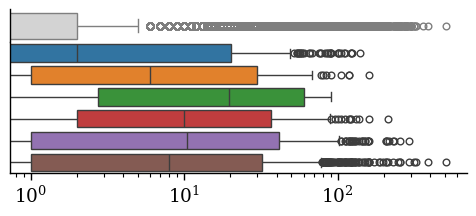

In [47]:
metric = 'aps_i10_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

i10_index


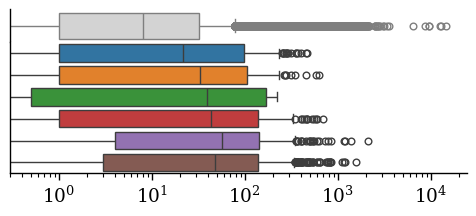

In [48]:
metric = 'i10_index'
print(metric)
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## E-index

aps_e_index


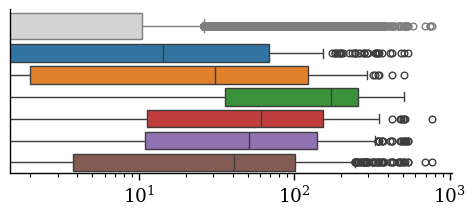

In [49]:
metric = 'aps_e_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

e_index


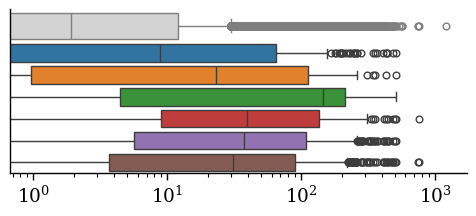

In [50]:
metric = 'e_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## Career age

aps_career_age


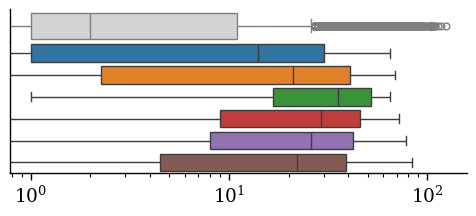

In [51]:
metric = 'aps_career_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

career_age


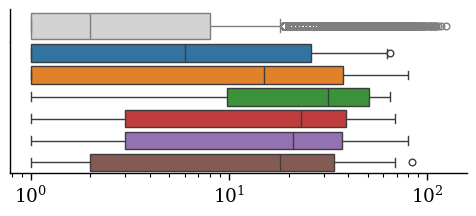

In [52]:
from matplotlib.pyplot import xlabel


metric = 'career_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## Others
e-index, normalized citation counts, and 2year_mean_citations

aps_citations_per_paper_age


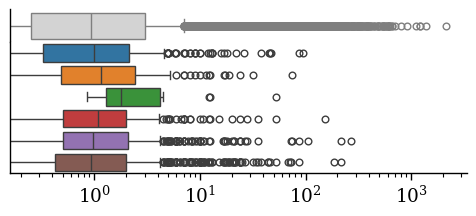

In [53]:
metric = 'aps_citations_per_paper_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

two_year_mean_citedness


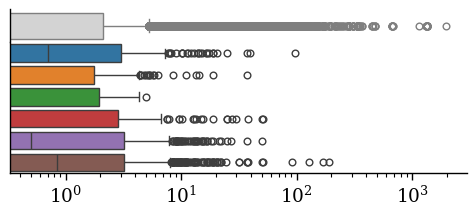

In [54]:
metric = 'two_year_mean_citedness'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

In [55]:
df_ranking_rec_stats[['model','task_name','task_param','name',
                      'aps_works_count','works_count', 'rr1_rank_publications','rr1_rank_publications_percentile',
                      'aps_cited_by_count','cited_by_count','rr2_rank_citations','rr2_rank_citations_percentile', 
                      'citations_per_paper_age',
                      'aps_h_index','h_index','rr3_rank_h_index','rr3_rank_h_index_percentile', 
                     ]]

df_ranking_rec_stats.columns

Index(['id_author_oa', 'clean_name', 'model', 'task_name', 'task_param',
       'date', 'time', 'created_date', 'updated_date', 'name', 'orcid',
       'two_year_mean_citedness', 'h_index', 'i10_index', 'works_count',
       'cited_by_count', 'ID', 'e_index', 'career_age', 'max_year', 'min_year',
       'citations_per_paper_age', 'rr1_rank_publications',
       'rr1_rank_publications_percentile', 'rr2_rank_citations',
       'rr2_rank_citations_percentile', 'rr3_rank_h_index',
       'rr3_rank_h_index_percentile', 'rr4_rank_i10_index',
       'rr4_rank_i10_index_percentile', 'rr5_rank_e_index',
       'rr5_rank_e_index_percentile', 'rr6_rank_citation_publication_age',
       'rr6_rank_citation_publication_age_percentile',
       'rr7_rank_mean_citedness_2yr', 'rr7_rank_mean_citedness_2yr_percentile',
       'aps_works_count', 'aps_cited_by_count', 'aps_h_index', 'aps_i10_index',
       'aps_e_index', 'aps_years_of_activity', 'aps_career_age',
       'aps_citations_per_paper_age'],
    

In [56]:
import pandas as pd

# metric = 'rr1_rank_publications_percentile'
# metric = 'rr2_rank_citations_percentile'
# metric = 'rr3_rank_h_index_percentile'
metric = 'career_age'

fname = f'{metric}.tex'
fn = io.path_join(LATEX_PATH, fname)


df = df_llm_real_authors.copy()


# Group by task_param and model, calculate mean and std
agg_df = df.groupby(['task_param', 'model'])[metric].agg(['mean', 'std']).reset_index()

# Format mean (std) in the same cell
agg_df['formatted'] = agg_df.apply(
    lambda row: f"{row['mean']:.1f} ({row['std']:.1f})", axis=1
)

# Pivot for better table structure
pivot_table = agg_df.pivot(index='task_param', columns='model', values='formatted')


# Replace NaN values with '-' for display
pivot_table = pivot_table.fillna('-')


# Reindex rows and columns to desired order
pivot_table = pivot_table.reindex(columns=constants.LLMS)


# Add row-wise mean and std summary
def compute_row_summary(group):
    vals = df[df['task_param'] == group].groupby('model')[metric].mean().values
    return f"{pd.Series(vals).mean():.1f}" #({pd.Series(vals).std():.1f})

pivot_table['Mean'] = pivot_table.index.map(compute_row_summary)

# Add column-wise mean and std summary
summary_row = {}
for col in pivot_table.columns[:-1]:  # exclude 'Mean (SD)' column
    vals = df[df['model'] == col][metric]
    summary_row[col] = f"{vals.mean():.1f}" #({vals.std():.1f})
summary_row['Mean'] = ''


# Append summary row to the table
pivot_table.loc['Mean'] = pd.Series(summary_row)

# Convert to LaTeX
latex_code = pivot_table.reset_index().to_latex(index=False, escape=True)
io.save_text(latex_code, fn)


print(latex_code)




\begin{tabular}{llllllll}
\toprule
task\_param & llama3-8b & llama-3.1-8b & gemma2-9b & mixtral-8x7b & llama3-70b & llama-3.1-70b & Mean \\
\midrule
1950s & 18.2 (21.1) & 30.1 (21.0) & 36.0 (21.6) & 28.0 (19.0) & 27.5 (22.6) & 29.5 (21.2) & 28.2 \\
2000s & - & - & - & 16.6 (17.7) & 34.7 (17.9) & 25.4 (18.5) & 25.6 \\
CM\&MP & 13.3 (11.4) & - & - & 18.6 (13.0) & 38.5 (21.3) & 31.2 (21.8) & 25.4 \\
PER & 10.4 (10.5) & 20.7 (20.7) & 16.0 (21.3) & 14.0 (16.7) & 16.8 (17.9) & 15.2 (18.8) & 15.5 \\
early\_career & 4.4 (8.8) & 2.6 (2.0) & - & 4.5 (3.5) & 39.0 (0.0) & 12.8 (11.3) & 12.6 \\
famous\_female & 28.7 (4.7) & 25.8 (10.6) & - & 20.4 (9.3) & 13.3 (11.3) & 19.3 (10.5) & 21.5 \\
famous\_male & 28.6 (4.8) & 29.0 (10.0) & - & - & 25.6 (3.7) & 25.2 (19.8) & 27.1 \\
fictitious\_female & 15.3 (9.3) & 34.3 (29.6) & - & 24.4 (21.8) & 12.0 (12.6) & 21.5 (18.3) & 21.5 \\
fictitious\_male & 8.4 (16.9) & 19.6 (19.1) & - & 36.0 (0.0) & 39.7 (10.3) & 20.1 (18.7) & 24.8 \\
movie\_female & - & - & - & 